In [100]:
import requests
import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt
import re
import json
from time import time
from nltk import word_tokenize, pos_tag, Text
from nltk.corpus import brown
import nltk.text
import numpy as np

## Reading the Data

In [74]:
with open('layer1.json') as f:
    recipe_data = json.load(f)

In [259]:
start = time()

ingredients_data = json_normalize(recipe_data,record_path='ingredients',meta="id")

#get the time taken
end = time()
print('Seconds:', end - start)

Seconds: 177.2327663898468


In [260]:
ingredients_data.sample(5)

,id,text
6112982,a2f69a1465,14 teaspoon ground cinnamon
1617379,2b32020665,"100 g feta, crumbled"
7827164,d073a2d20b,"1 15-ounce can black beans, rinsed, drained"
6909038,b8193e31ab,cooking spray
7905873,d28663f49b,2 tablespoons salt


## POS Tagging for Ingredients - Nouns

In [77]:
noun_tags = ['NN', 'NNS', 'NNP', 'NNPS']

def get_nouns(s):
    """
    This function inputs a string and returns the words tagged as nouns
    """
    text = word_tokenize(s)
    pos_tags = pos_tag(text)
    
    nouns = [item[0] for item in pos_tags if item[1] in noun_tags]
    return nouns

In [78]:
#get random sample of 1M ingredients
large_list_of_ingredients = ' '.join(ingredients_data.sample(1000000).text)

### 1M ingredients took ~15 minutes for me; I think 10000 is sufficient to get a good idea

In [79]:
#get the nouns from that big list
start = time()
nouns = get_nouns(large_list_of_ingredients)
end = time()
print('Seconds:', end - start)

Seconds: 913.2231004238129


## Noun Clusters

In [262]:
#input the nouns as text so we can find similar words
full_text = nltk.text.ContextIndex(nouns)

In [263]:
#for example, if we wish to find nouns similar to "apple"
start = time()

result = full_text.similar_words('apple')
print(result)

end = time()
print('Seconds:', end - start)

['orange', 'lemon', 'sugar', 'lime', 'butter', 'water', 'oil', 'milk', 'cream', 'onion', 'tablespoons', 'pineapple', 'flour', 'pepper', 'cup', 'wine', 'tomato', 'cups', 'teaspoon', 'parsley']
Seconds: 0.14760446548461914


In [264]:
#for example, if we wish to find nouns similar to "flour"
start = time()

result = full_text.similar_words('flour')
print(result)

end = time()
print('Seconds:', end - start)

['sugar', 'butter', 'water', 'cream', 'oil', 'milk', 'onion', 'wine', 'parsley', 'walnuts', 'pecans', 'rice', 'pepper', 'celery', 'cheese', 'mayonnaise', 'tablespoons', 'onions', 'teaspoon', 'cilantro']
Seconds: 0.3840019702911377


In [265]:
def get_additional_cluster_memebers(full_text, seed_words, words_to_omit=[], draw_graph=False):
    """
    This function inputs a list of words and some seed words.
    It tries to find more words in the list of words that are
    similar to the seed words so a cluster can be formed
    """
    
    num_seed_words = len(seed_words)
    
    #the fraction to add each time we see a similar word
    unit_fraction = round(1/num_seed_words, 4)
    
    #dynamically set number of similar words to get
    num_similar_words = 5 + len(words_to_omit)
    
    #this dictionary keeps track of how many times a similar word is seen
    membership_counts = dict()
    
    #for each seed word
    for word in seed_words:
        #get most similar words
        similar_words = full_text.similar_words(word, num_similar_words)
        
        #we don't want to see any seed words or words to omit in here
        similar_words_limited = [s for s in similar_words if s not in seed_words and s not in words_to_omit]
        
        #add them to the dictionary
        for s in similar_words_limited:
            #weight this score by its position in the similarity list
            weight = unit_fraction*(1/(similar_words_limited.index(s)+1))
            if s in membership_counts:
                membership_counts[s] += weight
            else:
                membership_counts[s] = weight
                
    if draw_graph:
        create_cluster_chart(membership_counts, seed_words)
    
    #return the similar words, ordered by how many times they were found as matches to seed words
    return sorted(membership_counts.items(), key = lambda item: -item[1])

In [266]:
def create_cluster_chart(membership_counts, seed_words):
    """
    Crate a bar chart for potential cluster members
    """
    
    plt.figure(figsize=(6,6))
    
    #get new top 5 suggested new members
    new_members = sorted(membership_counts.items(), key = lambda item: -item[1])[:5]
    new_members = new_members[::-1]
    new_words = [item[0] for item in new_members]
    
    #get the scores
    new_word_scores = [item[1] for item in new_members]
    
    #determine y positions
    y_pos = np.arange(len(new_members))

    #draw the bar chart
    plt.barh(y_pos, new_word_scores, align='center')
    plt.title('Additional Members for Seed Words:\n%s'%seed_words, fontsize=16)
    plt.yticks(y_pos, new_words, fontsize=14)
    #plt.invert_yaxis()  # labels read top-to-bottom
    plt.xlabel('Score')

[('lemon', 0.6666),
 ('sugar', 0.49995),
 ('lime', 0.27775),
 ('butter', 0.249975),
 ('onion', 0.11109999999999999),
 ('pineapple', 0.11109999999999999),
 ('water', 0.083325),
 ('vanilla', 0.083325),
 ('oil', 0.06666)]

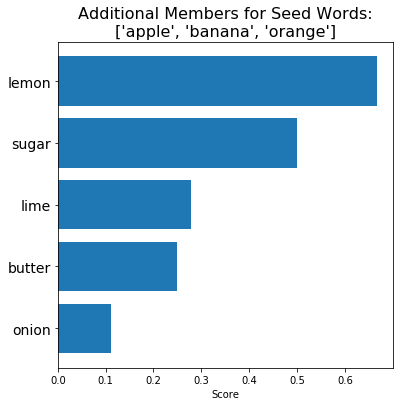

In [267]:
fruits = ['apple', 'banana', 'orange']
get_additional_cluster_memebers(full_text, fruits, draw_graph=True)

[('butter', 0.6666),
 ('oil', 0.583275),
 ('water', 0.38885),
 ('cream', 0.194425),
 ('pepper', 0.16665),
 ('teaspoon', 0.083325),
 ('milk', 0.06666)]

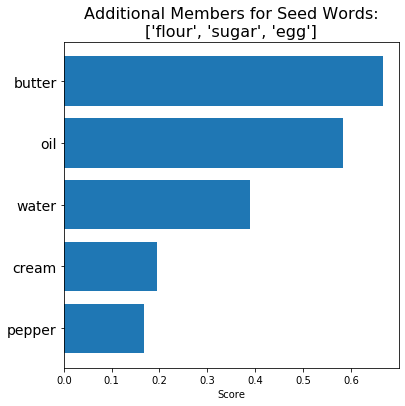

In [268]:
baking = ['flour', 'sugar', 'egg']
get_additional_cluster_memebers(full_text, baking, draw_graph=True)

[('cup', 0.83325),
 ('ground', 0.3333),
 ('tablespoons', 0.27775),
 ('cups', 0.27775),
 ('teaspoons', 0.16665),
 ('pepper', 0.14998499999999998),
 ('salt', 0.11109999999999999)]

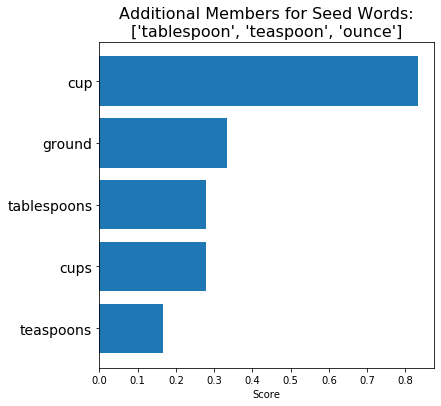

In [269]:
measurements = ['tablespoon', 'teaspoon', 'ounce']
get_additional_cluster_memebers(full_text, measurements, draw_graph=True)

[('cheddar', 0.9999),
 ('cream', 0.361075),
 ('mozzarella', 0.361075),
 ('sugar', 0.249975),
 ('chips', 0.11109999999999999),
 ('water', 0.06666),
 ('butter', 0.06666)]

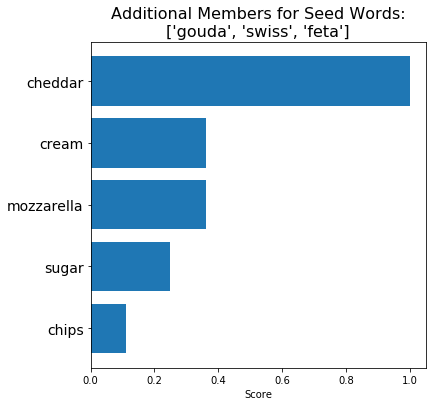

In [270]:
cheese = ['gouda', 'swiss', 'feta']
get_additional_cluster_memebers(full_text, cheese, draw_graph=True)

[('ground', 1.0),
 ('vanilla', 0.3958333333333333),
 ('powder', 0.37499999999999994),
 ('soda', 0.1875),
 ('teaspoon', 0.125),
 ('sugar', 0.05)]

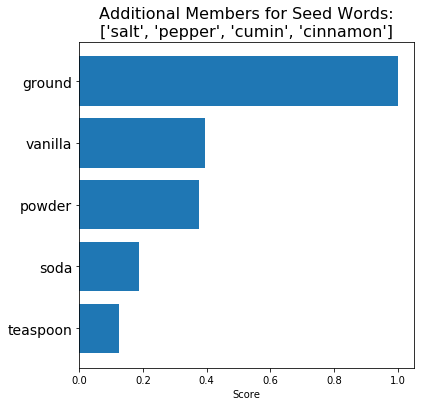

In [271]:
spices = ['salt', 'pepper', 'cumin', 'cinnamon']
get_additional_cluster_memebers(full_text, spices, draw_graph=True)

[('sugar', 0.6666),
 ('pepper', 0.6666),
 ('water', 0.249975),
 ('mushroom', 0.11109999999999999),
 ('butter', 0.11109999999999999),
 ('teaspoon', 0.11109999999999999),
 ('cream', 0.083325),
 ('ground', 0.083325),
 ('milk', 0.06666)]

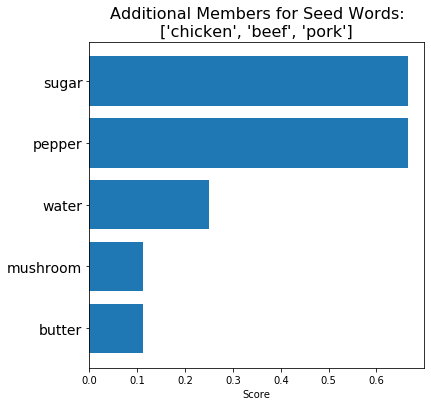

In [272]:
meat = ['chicken', 'beef', 'pork']
get_additional_cluster_memebers(full_text, meat, draw_graph=True)

### The "meat" cluster doesnt make too much sense; see experiment at the end for possible improvement

[('sugar', 0.75),
 ('butter', 0.3333333333333333),
 ('lemon', 0.25),
 ('water', 0.22916666666666663),
 ('onion', 0.125),
 ('cream', 0.125),
 ('lime', 0.125),
 ('apple', 0.08333333333333333),
 ('pineapple', 0.0625),
 ('juice', 0.05),
 ('vanilla', 0.05)]

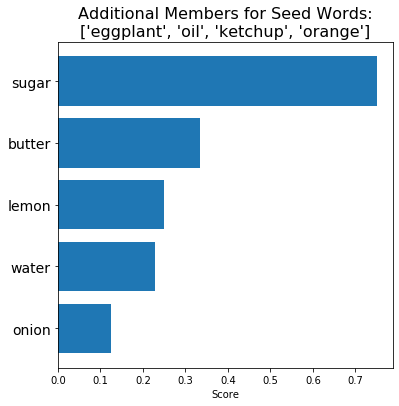

In [273]:
nonsense = ['eggplant', 'oil', 'ketchup', 'orange']
get_additional_cluster_memebers(full_text, nonsense, draw_graph=True)

### This last experiment was to see what happens if we put in nonsense words

# Frequency Count of the Nouns

In [274]:
noun_freqs = dict()
for noun in nouns:
    if noun in noun_freqs:
        noun_freqs[noun] += 1
    else:
        noun_freqs[noun] = 1

In [275]:
most_common_nouns = sorted(noun_freqs.items(), key=lambda item: -item[1])[:25]

In [276]:
for item in most_common_nouns:
    print('Noun:  %s'%item[0])
    print('Count: %s'%item[1])
    print('-----')

Noun:  cup
Count: 182696
-----
Noun:  teaspoon
Count: 110666
-----
Noun:  cups
Count: 83751
-----
Noun:  tablespoons
Count: 80332
-----
Noun:  tablespoon
Count: 46495
-----
Noun:  oil
Count: 42652
-----
Noun:  sugar
Count: 40074
-----
Noun:  pepper
Count: 39468
-----
Noun:  teaspoons
Count: 38453
-----
Noun:  ounce
Count: 34650
-----
Noun:  ground
Count: 32873
-----
Noun:  ounces
Count: 30269
-----
Noun:  butter
Count: 29125
-----
Noun:  onion
Count: 27866
-----
Noun:  salt
Count: 27769
-----
Noun:  water
Count: 24431
-----
Noun:  cream
Count: 23100
-----
Noun:  juice
Count: 22117
-----
Noun:  cheese
Count: 19590
-----
Noun:  tbsp
Count: 19540
-----
Noun:  powder
Count: 18914
-----
Noun:  milk
Count: 18414
-----
Noun:  tsp
Count: 17067
-----
Noun:  eggs
Count: 16401
-----
Noun:  vanilla
Count: 15871
-----


In [277]:
nouns_to_omit = [item[0] for item in most_common_nouns]

## What if we make these top nouns off-limits?

[('coriander', 0.6666),
 ('mushroom', 0.3333),
 ('flour', 0.3333),
 ('cloves', 0.249975),
 ('skinless', 0.16665),
 ('wine', 0.1587142857142857),
 ('celery', 0.1481333333333333),
 ('onions', 0.138875),
 ('thru', 0.11109999999999999),
 ('rice', 0.09999),
 ('walnuts', 0.09999),
 ('pecans', 0.09258333333333332),
 ('egg', 0.09229846153846154),
 ('parsley', 0.07791428571428571),
 ('beans', 0.07142142857142855),
 ('cinnamon', 0.0694375),
 ('tomatoes', 0.06480833333333333),
 ('stock', 0.055549999999999995),
 ('mayonnaise', 0.0303),
 ('oats', 0.025638461538461537)]

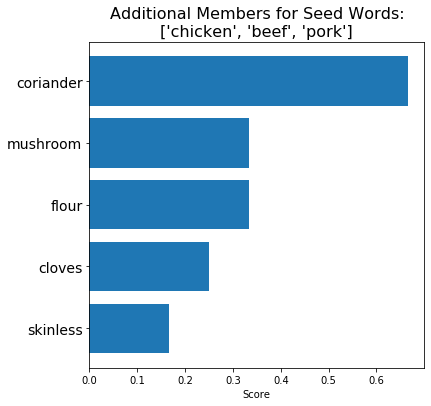

In [278]:
meat = ['chicken', 'beef', 'pork']
get_additional_cluster_memebers(full_text, meat, nouns_to_omit, True)

### In my opinion, the "meat" cluster now makes a bit more sense

[('cheddar', 0.9999),
 ('mozzarella', 0.49995),
 ('jack', 0.24441999999999997),
 ('flour', 0.194425),
 ('parmesan', 0.194425),
 ('goat', 0.1698242857142857),
 ('wine', 0.1309392857142857),
 ('chips', 0.11109999999999999),
 ('romano', 0.0976092857142857),
 ('walnuts', 0.07869583333333333),
 ('parsley', 0.06733333333333333),
 ('rice', 0.06730096153846153),
 ('pecans', 0.06666),
 ('kraft', 0.05786458333333333),
 ('mayonnaise', 0.054107142857142854),
 ('celery', 0.053413461538461535),
 ('onions', 0.04305125),
 ('pieces', 0.0416625),
 ('cottage', 0.03333),
 ('blend', 0.0303),
 ('provolone', 0.027774999999999998),
 ('ricotta', 0.025638461538461537),
 ('parmigiano-reggiano', 0.023807142857142853),
 ('cilantro', 0.023807142857142853),
 ('pecorino', 0.02222),
 ('chip', 0.02083125),
 ('morsels', 0.019605882352941174),
 ('honey', 0.019605882352941174),
 ('mascarpone', 0.018516666666666664),
 ('raisins', 0.018516666666666664),
 ('fontina', 0.017542105263157894),
 ('almonds', 0.017542105263157894),

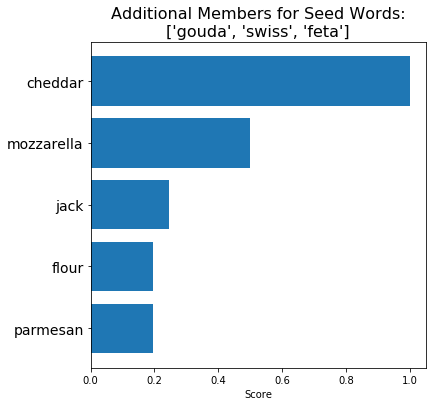

In [279]:
cheese = ['gouda', 'swiss', 'feta']
get_additional_cluster_memebers(full_text, cheese, nouns_to_omit, True)

### The "cheese" cluster also got a bit of improvement